<hr>

## CSCI 5952 E01 – Spring 2021
## Big Data Science
### Final Project
#### Team: Rumana Sultana
<hr>

<h3> Importing libraries and initializing variables </h3>

In [10]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-f59nakbf
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-f59nakbf
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101064 sha256=16484a8b516c35712a02957bcbfebd2984abd3ac299b8f711bacdb7a4aae9ecb
  Stored in directory: /tmp/pip-ephem-wheel-cache-2a4nlqaf/wheels/67/d2/f4/96ae3c3c62d1e05abfc8860ad0c1207794726d44ebbbb547f3
Successfully built keras-contrib
Note: you may need to restart the kernel to use updated packages.


In [2]:
git clone https://github.com/forrestbao/pyeeg.git

SyntaxError: invalid syntax (<ipython-input-2-b76b3e275ed4>, line 1)

In [1]:
%matplotlib inline

import glob
import math
import ntpath
import random, os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import edfreader
import models
import mne
import pyeeg
import warnings
warnings.filterwarnings('ignore')

from matplotlib.backends.backend_pdf import PdfPages
from mne.datasets.sleep_physionet._utils import _fetch_one, _data_path, AGE_SLEEP_RECORDS, _check_subjects
from datetime import datetime
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import psd_welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import joblib
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, log_loss
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost

VBS = True  # constant boolean to enable/disbale verbose
EPOCH_SEC_SIZE = 30  # Epoch duration selection
seed = 42  # seed value for the random seeds
batch_size = 64
number_of_subj = 50

# values to label the stages
UNKNOWN = -1
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4

# making string dictionary for the label values
label_dict = {
    "UNKNOWN"  : UNKNOWN,
    "W"        : W,
    "N1"       : N1,
    "N2"       : N2,
    "N3"       : N3,
    "REM"      : REM
}

# converting from label values to strings 
class_dict = {
    -1: "UNKNOWN",
    0 : "W",
    1 : "N1",
    2 : "N2",
    3 : "N3",
    4 : "REM"
}

# annotation dictionary to convert from string to label values
annot2label = {
    "Sleep stage ?": -1,
    "Movement time": -1,
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4
}
project_path = os.path.abspath(os.getcwd())  # finding the current project path in windows

<h3> Localizing fetch_data function to import all subjects </h3>

In [2]:
# localized fetch_data function by using mne library
# https://github.com/mne-tools/mne-python/blob/maint/0.20/mne/datasets/sleep_physionet/age.py#L18-L111
data_path = _data_path
BASE_URL = 'https://physionet.org/physiobank/database/sleep-edfx/sleep-cassette/'
def fetch_data(subjects, recording=[1, 2], path=None, force_update=False,
               update_path=None, base_url=BASE_URL,
               verbose=None):  # noqa: D301
    records = np.loadtxt(AGE_SLEEP_RECORDS,
                         skiprows=1,
                         delimiter=',',
                         usecols=(0, 1, 2, 6, 7),
                         dtype={'names': ('subject', 'record', 'type', 'sha',
                                          'fname'),
                                'formats': ('<i2', 'i1', '<S9', 'S40', '<S22')}
                         )
    psg_records = records[np.where(records['type'] == b'PSG')]
    hyp_records = records[np.where(records['type'] == b'Hypnogram')]

    path = data_path(path=path, update_path=update_path)
    params = [path, force_update, base_url]
    fnames = []
    for subject in subjects:
        for idx in np.where(psg_records['subject'] == subject)[0]:
            if psg_records['record'][idx] in recording:
                psg_fname = _fetch_one(psg_records['fname'][idx].decode(),
                                       psg_records['sha'][idx].decode(),
                                       *params)
                hyp_fname = _fetch_one(hyp_records['fname'][idx].decode(),
                                       hyp_records['sha'][idx].decode(),
                                       *params)
                fnames.append([psg_fname, hyp_fname])

    return fnames

<h3> Reading input data </h3>

In [3]:
subjects_list = []  # list to keep the address of the subject data
except_sub = [13, 36, 52]  # omitting the subjects with incomplete data 
for i in range(83):
    if i in except_sub:
        continue
    subjects_list.append(i)
# fetching data of each subject and 
subject_files = fetch_data(subjects=subjects_list, recording=[1, 2], path= project_path)  
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

<h3> Sampling data and saving the results in NPZ format </h3>

In [4]:
ch_labels = 'EEG Fpz-Cz'  # channels to be selected
data_frames = []
if VBS:
    print("Importing data into dataframes:")
output_path = os.path.join(project_path, "NPZ_files")  # path to save the npz files
# loop to preprocess input data and save the results in npz files to be used in our models later
for item in tqdm(subject_files):
    filename = ntpath.basename(item[0]).replace("-PSG.edf", ".npz")  # reading the PSG files
    if not os.path.exists(os.path.join(output_path, filename)):
        raw_train = mne.io.read_raw_edf(item[0], verbose=VBS)
        sampling_rate = raw_train.info['sfreq']
        raw_ch_df = raw_train.to_data_frame()[ch_labels]
        raw_ch_df = raw_ch_df.to_frame()
        raw_ch_df.set_index(np.arange(len(raw_ch_df)))
        
        # reading the raw headers using the EDFReader function from edfreader
        f = open(item[0], 'r', errors='ignore', encoding='utf-8')
        head_raw_read = edfreader.BaseEDFReader(f)
        head_raw_read.read_header()
        head_raw = head_raw_read.header
        f.close()
        raw_start_time = datetime.strptime(head_raw['date_time'], "%Y-%m-%d %H:%M:%S")

        # read annotations from hypnogram file
        f = open(item[1], 'r')
        annot_raw_read = edfreader.BaseEDFReader(f)
        annot_raw_read.read_header()
        annot_raw = annot_raw_read.header
        temp, temp, total_annot = zip(*annot_raw_read.records())
        f.close()
        annot_start_time = datetime.strptime(annot_raw['date_time'], "%Y-%m-%d %H:%M:%S")
        assert raw_start_time == annot_start_time  # making sure that the PSG files and hypnogram files are in sync
        remove_idx = []    # list to keep the indicies of data that will be removed
        labels = []        # list to keep the indicies of data that have labels
        label_idx = []
        
        # selecting the indicies of known labels and adding the rest to remove_idx list
        for annot in total_annot[0]:
            onset_sec, duration_sec, annot_char = annot
            annot_str = "".join(annot_char)
            label = annot2label[annot_str]
            if label != UNKNOWN:
                if duration_sec % EPOCH_SEC_SIZE != 0:
                    raise Exception("Please choose anothe epoch duration!")
                duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
                label_epoch = np.ones(duration_epoch, dtype=np.int) * label
                labels.append(label_epoch)
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                label_idx.append(idx)
            else:
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                remove_idx.append(idx)
        labels = np.hstack(labels)
        if len(remove_idx) > 0:
            remove_idx = np.hstack(remove_idx)
            select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
        else:
            select_idx = np.arange(len(raw_ch_df))

        # filtering data with labels only
        label_idx = np.hstack(label_idx)
        select_idx = np.intersect1d(select_idx, label_idx)

        # removing extra indicies
        if len(label_idx) > len(select_idx):
            extra_idx = np.setdiff1d(label_idx, select_idx)
            # trimming the tail
            if np.all(extra_idx > select_idx[-1]):
                n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
                n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
                select_idx = select_idx[:-n_trims]
                labels = labels[:-n_label_trims]

        # removing all unknown and movement labels
        raw_ch = raw_ch_df.values[select_idx]

        # check if we can split into epochs' size
        if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
            raise Exception("Please choose anothe epoch duration!")
        n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

        # get epochs and their corresponding labels
        x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
        y = labels.astype(np.int32)

        assert len(x) == len(y)

        # select on sleep periods
        w_edge_mins = 30
        nw_idx = np.where(y != label_dict["W"])[0]
        start_idx = nw_idx[0] - (w_edge_mins * 2)
        end_idx = nw_idx[-1] + (w_edge_mins * 2)
        if start_idx < 0: start_idx = 0
        if end_idx >= len(y): end_idx = len(y) - 1
        select_idx = np.arange(start_idx, end_idx+1)
        x = x[select_idx]
        y = y[select_idx]

        # file structure for saving
        save_dict = {
            "x": x, 
            "y": y, 
            "fs": sampling_rate,
            "ch_label": ch_labels,
            "header_raw": head_raw,
            "header_annotation": annot_raw,
        }
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        np.savez(os.path.join(output_path, filename), **save_dict)

Importing data into dataframes:


<h3> Plotting the first 20 subjects and saving the results in a PDF file </h3>

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

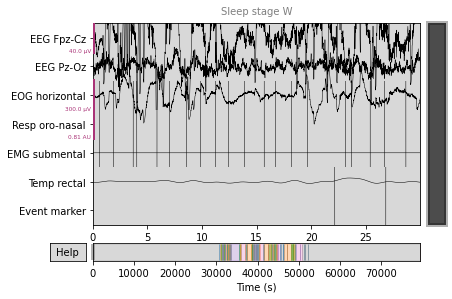

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


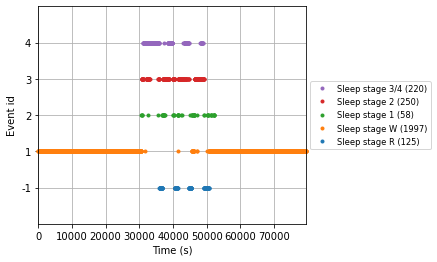

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

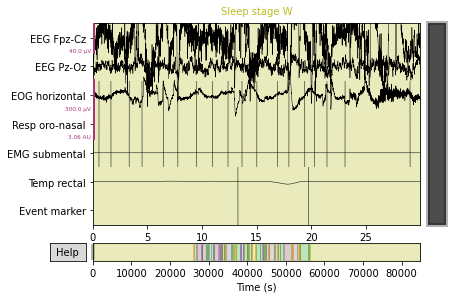

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


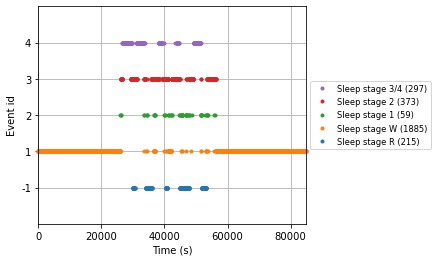

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

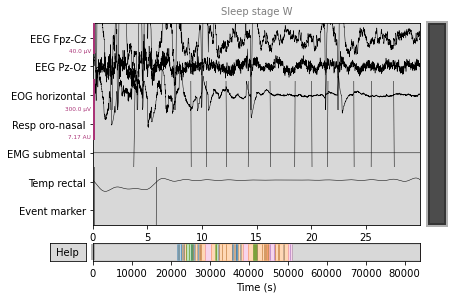

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


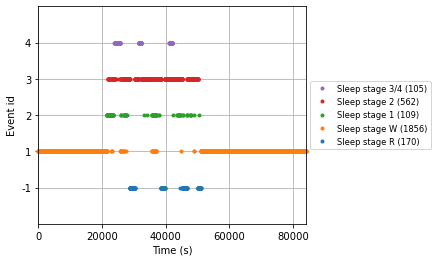

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

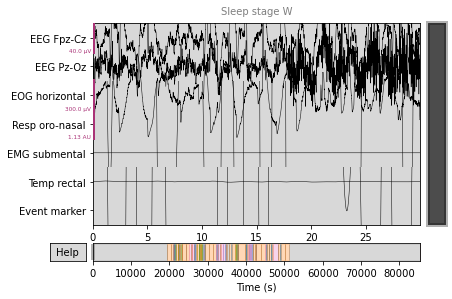

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


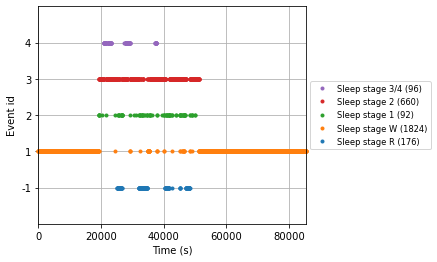

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

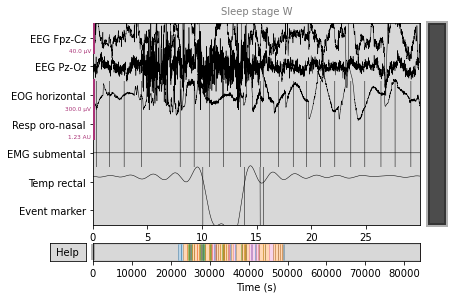

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


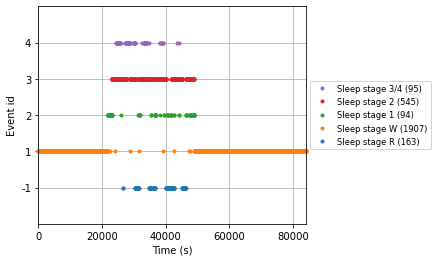

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4022E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

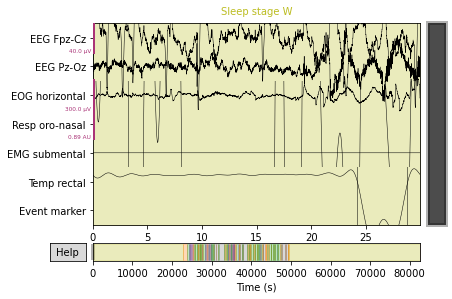

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


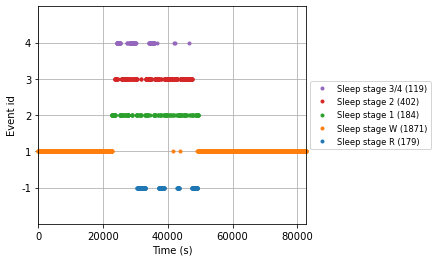

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

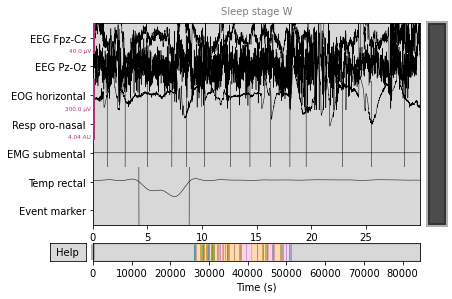

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


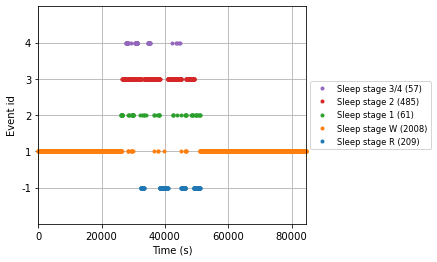

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4032E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

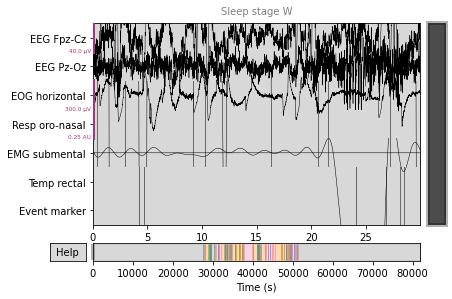

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


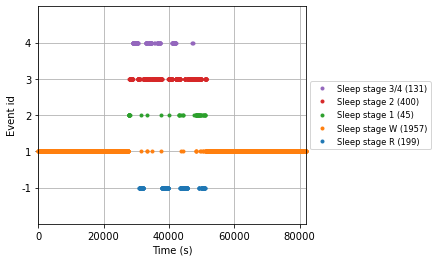

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

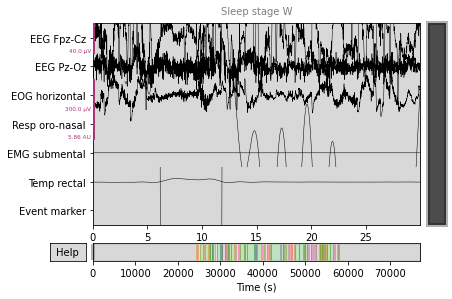

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']


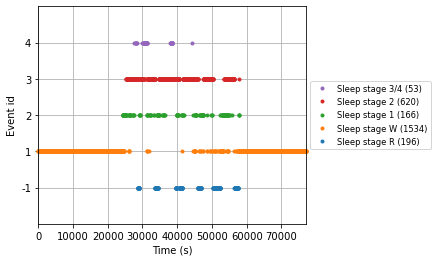

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4042E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

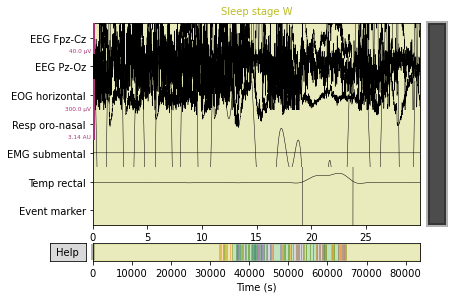

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


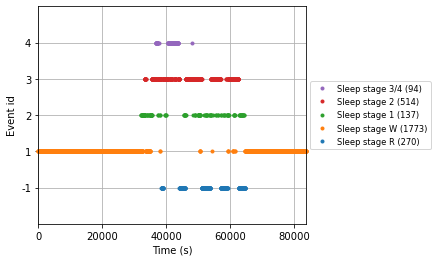

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

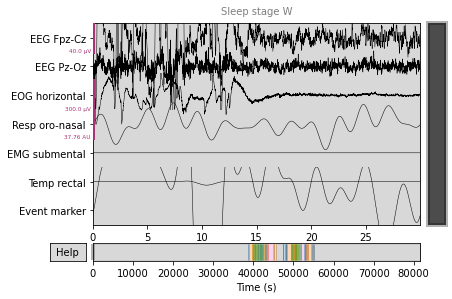

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


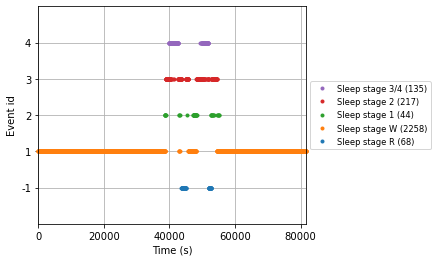

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4052E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

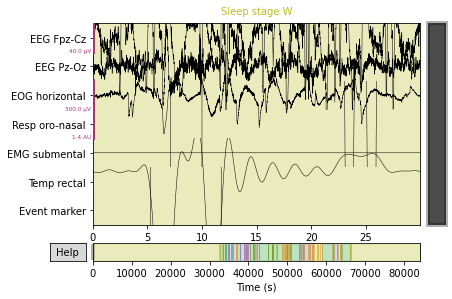

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


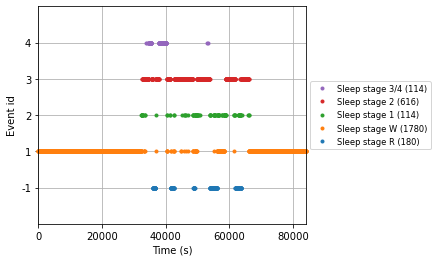

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4061E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

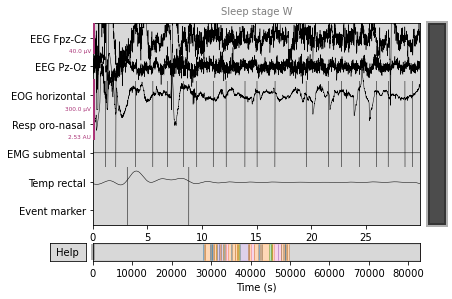

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


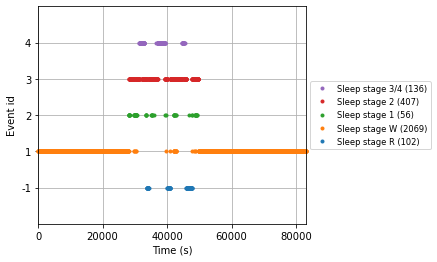

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4062E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

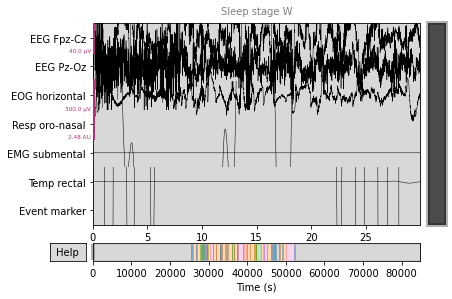

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


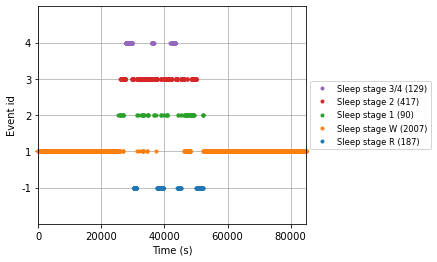

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4071E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

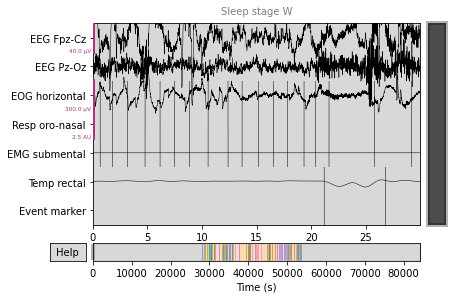

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


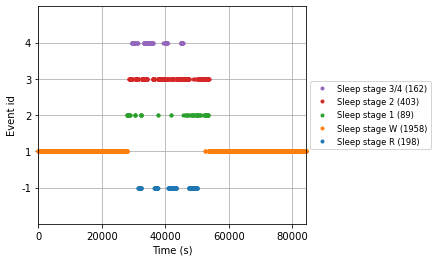

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4072E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

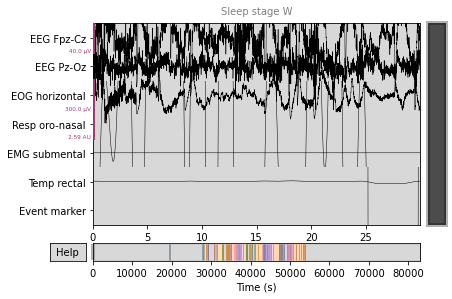

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


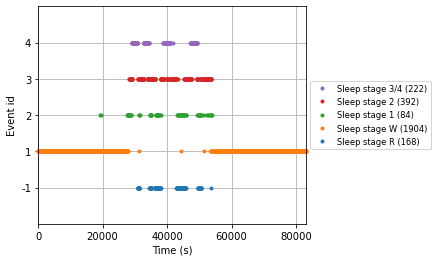

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4081E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

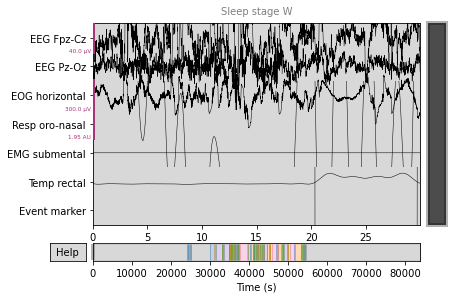

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


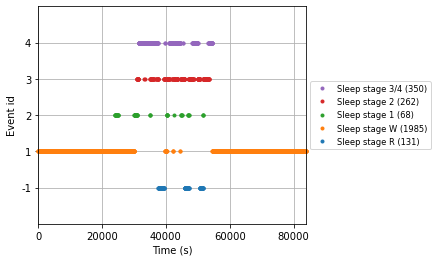

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4082E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

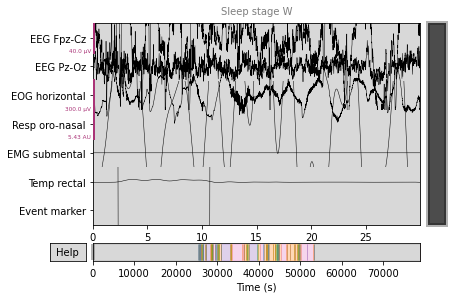

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


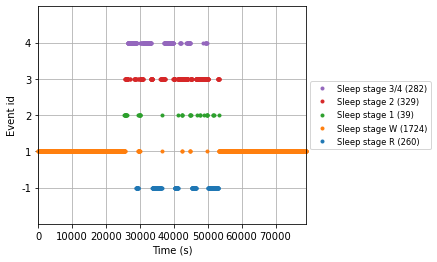

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4091E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

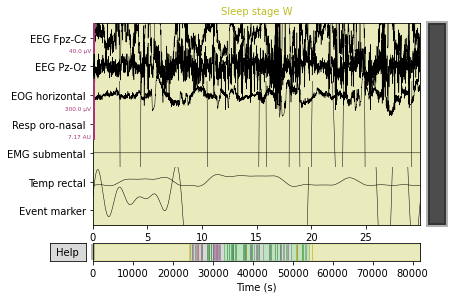

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


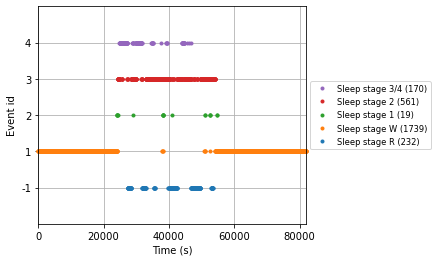

Extracting EDF parameters from /home/rumana/Desktop/Deep_learner/Sleep-Stage-Classification-master/physionet-sleep-data/SC4092E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

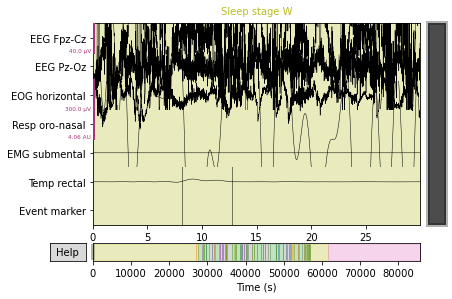

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


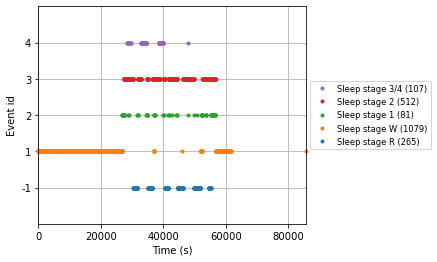

In [5]:
# plotting some of the subjects' raw signals and thier sleep stage
pdf_report = PdfPages('Sleep_Plots.pdf')
for item in tqdm(subject_files[:20]):  # selecting the first 20 subjects
    raw_train = mne.io.read_raw_edf(item[0], verbose=VBS)
    annot_train = mne.read_annotations(item[1])  # reading the hypnogram files

    raw_train.set_annotations(annot_train, emit_warning=False)
    raw_train.set_channel_types(mapping)
    figure = plt.figure()
    figure.suptitle("Subject: " + str(item[0][-13:-11]) + ", Night: " + str(item[0][-11:-10]))
    pdf_report.savefig(figure, papertype='a0', bbox_inches='tight')
    pdf_report.savefig(raw_train.plot(duration=30), papertype='a0', bbox_inches='tight')

    annotation_desc_2_event_id = {'Sleep stage R': -1,
                                  'Sleep stage W': 1,
                                  'Sleep stage 1': 2,
                                  'Sleep stage 2': 3,
                                  'Sleep stage 3': 4,
                                  'Sleep stage 4': 4
    }

    events_train, _ = mne.events_from_annotations(
        raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage R'  : -1,
                'Sleep stage W'  : 1,
                'Sleep stage 1'  : 2,
                'Sleep stage 2'  : 3,
                'Sleep stage 3/4': 4
    }
    # plot events and saving them in PDF report
    pdf_report.savefig(mne.viz.plot_events(events_train, event_id=event_id,
                        sfreq=raw_train.info['sfreq']), bbox_inches='tight')
pdf_report.close()

<h3> Features Extraction </h3>

In [9]:
from hurst import compute_Hc
Fs= 100
band_list = [0.5,4,7,12,30]
PSD = []  # Power Spectral Density
PFD = []  # Petrosian Fractal Dimension
hjorths = []  # Hjorth Parameters
hursts = []  # Hurst Exponent
DFA = []  # Detrended Fluctuation Analysis
for item in tqdm(subject_files[:5]):
    raw_test = mne.io.read_raw_edf(item[0], verbose=False)
    signals_list = raw_test[0][0][0]
    first_order = np.diff(signals_list).tolist()
    PSD.append(pyeeg.bin_power(signals_list, band_list, Fs))
    PFD.append(pyeeg.pfd(signals_list, first_order))
    hjorths.append(pyeeg.hjorth(signals_list, first_order))
    hursts.append(compute_Hc(signals_list, kind='change', min_window=100))
    DFA.append(pyeeg.dfa(signals_list))

In [10]:
if VBS:
    print("Petrosian Fractal Dimension (PFD): ", PFD)
    print("Hjorth mobility and complexity: ", hjorths)
    print("Detrended Fluctuation Analysis (DFA): ", DFA)
    print("Hurst Exponent (Hurst): ", hursts)

Petrosian Fractal Dimension (PFD):  [0.5260813226365344, 0.524797335166937, 0.5296215973392818, 0.5294222017464901, 0.5267916487609091]
Hjorth mobility and complexity:  [(0.0001242622534516733, 13143.036280788516), (0.00018132418018598445, 9335.362942673955), (5.907335927673209e-05, 20875.12130562849), (6.000383534000729e-05, 21344.445095750732), (9.11423315792555e-05, 17072.109438632604)]
Detrended Fluctuation Analysis (DFA):  [0.13913468824876532, 0.2394063503787971, 0.19817581210316132, 0.2009850559755579, 0.19821142314924317]
Hurst Exponent (Hurst):  [(0.5835558023705112, 1.9675214804449517, [[100, 177, 316, 562, 1000, 1778, 3162, 5623, 10000, 17782, 31622, 56234, 100000, 177827, 316227, 562341, 1000000, 1778279, 3162277, 5623413, 7950000], [66.155289324895, 78.03278176625084, 92.8269827023827, 109.1797641429729, 127.685467256491, 148.35310840475495, 170.87570151326753, 199.11435939199475, 236.607566194322, 295.30064301639317, 401.0119507395091, 567.6520016324292, 867.8478412872066

<h3> Reading NPZ files for training dataset </h3>

In [11]:
npz_files = sorted(glob.glob(os.path.join(output_path, "*.npz")))
X = np.zeros((0, 3000, 1))
y = []
for fn in tqdm(npz_files[:number_of_subj]):
    samples = np.load(fn)
    X_data = samples['x']
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples['y'])
y = np.array(y)

Text(0.5, 1.0, 'Frequency of the labels in our dataset')

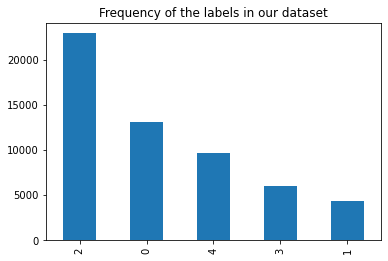

In [12]:
pd.Series(y).value_counts().plot.bar()
plt.title("Frequency of the labels in our dataset")

In [13]:
if VBS:
    print("Shape of the input data: {}".format(X.shape))
    print("Shape of the sleep stages: {}".format(y.shape))
# splitting subjects
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
# splitting sleeping signals
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)
if VBS:
    print("Shape of the training dataset:\ntraining dataset: {}\ntest_dataset: {}\n"
          .format(X_train.shape, X_test.shape))
y_train_ = to_categorical(y_train)
y_val_ = to_categorical(y_val)
y_test_ = to_categorical(y_test)

# X_train = np.squeeze(X_train)
# X_test = np.squeeze(X_test)
# X_val = np.squeeze(X_val)

Shape of the input data: (55989, 3000, 1)
Shape of the sleep stages: (55989,)
Shape of the training dataset:
training dataset: (45351, 3000, 1)
test_dataset: (5599, 3000, 1)



In [14]:
input_shape=X_train.shape[2]

In [15]:
input_shape=(X_train.shape[1], X_train.shape[2])

In [16]:
input_shape

(3000, 1)

In [17]:
checkpoint = ModelCheckpoint("model_cps", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
redonplat = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=5, verbose=2)
csv_logger = CSVLogger('log_training.csv', append=True, separator=',')
callbacks_list = [
    checkpoint,
    redonplat,
    csv_logger,
]

In [19]:
import tensorflow.keras as keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense

In [20]:
model = Sequential()
model.add(Conv1D(64, kernel_size=5,strides=3, padding = "same",activation="relu", input_shape=input_shape))
model.add(Conv1D(128, kernel_size=5,strides=1, padding = "same",activation="relu", input_shape=input_shape))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=13,strides=1, padding = "same",activation="relu"))
model.add(Conv1D(256, kernel_size=7,strides=1, padding = "same",activation="relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(256,kernel_size=7,strides=1, padding = "same", activation="relu"))
model.add(Conv1D(64,kernel_size=4,strides=1, padding = "same", activation="relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(32,kernel_size=3,strides=1, padding = "same", activation="relu"))
model.add(Conv1D(64,kernel_size=6,strides=1, padding = "same", activation="relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(8,kernel_size=5,strides=1, padding = "same", activation="relu"))
model.add(Conv1D(8,kernel_size=2,strides=1, padding = "same", activation="relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1000, 64)          384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 128)         41088     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 500, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 128)          213120    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 256)          229632    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 256)          0

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
             metrics=['accuracy'])

In [22]:
hist_19 = model.fit(
    X_train, y_train_, batch_size=batch_size, epochs=30, validation_data=(X_val, y_val_), callbacks=callbacks_list, verbose=VBS
)

Epoch 1/30
709/709 [==============================] - 921s 1s/step - loss: 0.9942 - val_loss: 0.6076

Epoch 00001: val_loss improved from -inf to 0.60760, saving model to model_cps
INFO:tensorflow:Assets written to: model_cps/assets
Epoch 2/30
709/709 [==============================] - 851s 1s/step - loss: 0.5446 - val_loss: 0.5524

Epoch 00002: val_loss did not improve from 0.60760
Epoch 3/30
709/709 [==============================] - 851s 1s/step - loss: 0.4958 - val_loss: 0.5189

Epoch 00003: val_loss did not improve from 0.60760
Epoch 4/30
709/709 [==============================] - 852s 1s/step - loss: 0.4712 - val_loss: 0.5238

Epoch 00004: val_loss did not improve from 0.60760
Epoch 5/30
709/709 [==============================] - 851s 1s/step - loss: 0.4569 - val_loss: 0.4335

Epoch 00005: val_loss did not improve from 0.60760
Epoch 6/30
709/709 [==============================] - 851s 1s/step - loss: 0.4340 - val_loss: 0.4330

Epoch 00006: val_loss did not improve from 0.60760

E

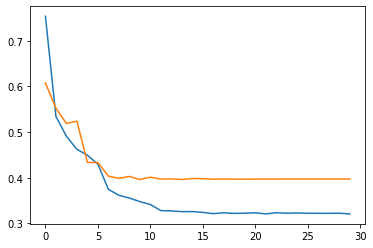

In [24]:
plt.plot(hist_19.history["loss"])
plt.plot(hist_19.history["val_loss"])